# Word2Vec + LSTM

In this notebook, we implement an approach that combines Word2Vec and LSTM to tackle sentiment classification on our dataset. The rationale behind this method is to leverage the strengths of both techniques: Word2Vec for capturing semantic relationships between words by representing them in a continuous vector space, and LSTM for modeling the sequential nature and contextual dependencies within the text.

In [1]:
!pip install -q gdown gensim

In [2]:
# import
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gdown
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import KeyedVectors

# Load Dataset, Data Understanding

In this section, we download a 500k-row subset of the Amazon Review Full dataset from Google Drive. The dataset is preprocessed.

In [3]:
file_id = '1-37ppWxcfONOFxooGUIulpp6y1h_af2f'
output_name = 'dataset_v2_500K_p.csv'

!gdown --id {file_id} -O {output_name}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-37ppWxcfONOFxooGUIulpp6y1h_af2f
From (redirected): https://drive.google.com/uc?id=1-37ppWxcfONOFxooGUIulpp6y1h_af2f&confirm=t&uuid=0a2f4b10-a52f-42c2-b593-2798da1f6179
To: /content/dataset_v2_500K_p.csv
100% 141M/141M [00:00<00:00, 201MB/s]


In [4]:
# Set options to show full text and all rows
pd.set_option('display.max_colwidth', None)
# Read the training data into a DataFrame
df_train = pd.read_csv('dataset_v2_500K_p.csv', header=None)
df_train.columns = ['Text', 'Rating']
# Display the first few rows
df_train.head()

<ipython-input-4-017c3f3f5487>:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('dataset_v2_500K_p.csv', header=None)


,Text,Rating
0,Text,Rating
1,no lonesome dove lonesome dive one good book ever read dead man walk can not hold candle ranger portray bumble idiot capture ambush easily pick baby especially not like end think call gus would buffalo hump not not spoil end still good read no lonesome dove street laredo excellent read find garage sale thrift store cheap price mean pick,3
2,not hoping not expect magicali pretty easy tool not toughon one stuck bolt first one use break without even give fight nd one grab well bu bent like piece licoricei would recommend lightduty workfortunately amazon amazing return process,2
3,roof bag bag hold good however not waterproof dry clothe arrive atour destination,2
4,suspensful truly read review write previous reader book read book intrigue ultimately premise story bengal tiger lose north georgia awesome all_caps read first half story find comparison movie jaw mystique suspense great story tell depict warner speilber second half story wander bit root go metaphorical shift one manhood truly wish many read story could not put _ also jim grahams character story truly charasmatic geniune read all_caps all_caps,5


After that, we perform some basic operations and checks on the DataFrame.

In [5]:
df_train['Rating'] = pd.to_numeric(df_train['Rating'], errors='coerce').astype('Int64')
df_train = df_train.drop(index=0).reset_index(drop=True)
df_train.head()

,Text,Rating
0,no lonesome dove lonesome dive one good book ever read dead man walk can not hold candle ranger portray bumble idiot capture ambush easily pick baby especially not like end think call gus would buffalo hump not not spoil end still good read no lonesome dove street laredo excellent read find garage sale thrift store cheap price mean pick,3
1,not hoping not expect magicali pretty easy tool not toughon one stuck bolt first one use break without even give fight nd one grab well bu bent like piece licoricei would recommend lightduty workfortunately amazon amazing return process,2
2,roof bag bag hold good however not waterproof dry clothe arrive atour destination,2
3,suspensful truly read review write previous reader book read book intrigue ultimately premise story bengal tiger lose north georgia awesome all_caps read first half story find comparison movie jaw mystique suspense great story tell depict warner speilber second half story wander bit root go metaphorical shift one manhood truly wish many read story could not put _ also jim grahams character story truly charasmatic geniune read all_caps all_caps,5
4,receive broken son receive gift bowl break tell call company not do yet not know resolution,2


In [6]:
# Show total null values in each column
df_train.isnull().sum()

,0
Text,4
Rating,0


In [7]:
df_train = df_train.dropna().reset_index(drop=True)
df_train.isnull().sum()

,0
Text,0
Rating,0


In [8]:
# Check how many duplicate rows exist
df_train.duplicated().sum()

25

In [9]:
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_train.duplicated().sum()

0

The rating distribution is well balanced, with each class representing roughly 20% of the data. This reduces the risk of class imbalance affecting model performance.

In [10]:
df_train['Rating'].value_counts(normalize=True) * 100

,proportion
Rating,
5,20.053363
3,20.045163
1,20.023561
2,19.944757
4,19.933156


In [11]:
# Number of rows
print("Number of rows:", len(df_train))

# Check for null values
if df_train.isnull().values.any():
    print("There are null elements in the DataFrame.")
else:
    print("There are no null elements in the DataFrame.")

Number of rows: 499971
There are no null elements in the DataFrame.


To simplify the classification task, we convert the problem to binary sentiment analysis.
Ratings of 4 and 5 are labeled as positive (1), while 1 and 2 are labeled as negative (0).
Neutral reviews (rating = 3) are excluded from the dataset.

In [12]:
# Keep only positive (4,5) and negative (1,2) ratings
# throw away neutral reviews with rating = 3
df_train = df_train[df_train['Rating'] != 3].copy()

df_train['sentiment'] = df_train['Rating'].apply(lambda x: 1 if x > 3 else 0)

In [13]:
df_train['sentiment'].value_counts()

,count
sentiment,
1,199921
0,199830


In [14]:
df_train.head(10)

,Text,Rating,sentiment
1,not hoping not expect magicali pretty easy tool not toughon one stuck bolt first one use break without even give fight nd one grab well bu bent like piece licoricei would recommend lightduty workfortunately amazon amazing return process,2,0
2,roof bag bag hold good however not waterproof dry clothe arrive atour destination,2,0
3,suspensful truly read review write previous reader book read book intrigue ultimately premise story bengal tiger lose north georgia awesome all_caps read first half story find comparison movie jaw mystique suspense great story tell depict warner speilber second half story wander bit root go metaphorical shift one manhood truly wish many read story could not put _ also jim grahams character story truly charasmatic geniune read all_caps all_caps,5,1
4,receive broken son receive gift bowl break tell call company not do yet not know resolution,2,0
5,computer literate little bit not read may already notice title review one bad technothriller one could choose reading would really annoyed dilettante write regard author knowledge cryptography computer mind popularity dan brown one good sell author book complete waste time sorry say give book unfortunately no star rating,1,0
6,not all_caps sequel iron monkey run mill hong kong actioner fan probably enjoy although not much donnie yen good action fighting sequence good yuen will ping design fight filming edit overall quality mediocre fan expect sort low budget quality hk all_caps action film really believe tai seng attempt cash popularity iron monkey frankly do poor job serious fan detect absolutely no connection story,2,0
7,nice read read many singer bio come across simionato decide read ok book not entertain basically chronology performance critical review real biography varnay c ludwigs b nilssons bio far entertain thorough tribute chapter way long all_caps hardcore fan,4,1
8,cheaply make buy digital camera vacation embarrase ever since cheapness quality camera battery door fall battery run quickly not stay second cause picture taker miss shot spend good deal camera upgrade digital card rarely use piece junk not buy another vivitar one worth money buy well brand like canon nikon nikon coolpix love wish would spend money first time instead vivitar,1,0
9,work ps ok all_caps let get straight yes all_caps work ps becuase ps ps outlet type electricy quantity lcd all_caps screen tv car must,5,1
10,interesting introduction philosophy another review book point fact not cover classic philosophy find interesting introduction discipline book require reading master level philosophy course thus force read find enlightening due naturei try circle classic often difficult time relate modern world book use modern writer great job connect basic problem philosophy modern day,4,1


## Subsample and Splin Train vs Internal Test set

We split the dataset into training and internal test sets, using an 80/20 ratio.
Stratified sampling is applied to preserve the original sentiment class distribution in both subsets.

In [15]:
X = df_train['Text']
y = df_train['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Tokenization

We initialize a Keras tokenizer with a vocabulary size limit of 30,000 words and an out-of-vocabulary token (<OOV>).
The tokenizer is fitted on the training set and then used to convert both the training and test texts into sequences of integer tokens.

In [16]:
# Set vocabulary size
max_words = 30000
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
# fit the tokenizer on TR set
tokenizer.fit_on_texts(X_train)
# tokenize TR set
train_sequences = tokenizer.texts_to_sequences(X_train)
# tokenize TS set
test_sequences = tokenizer.texts_to_sequences(X_test)

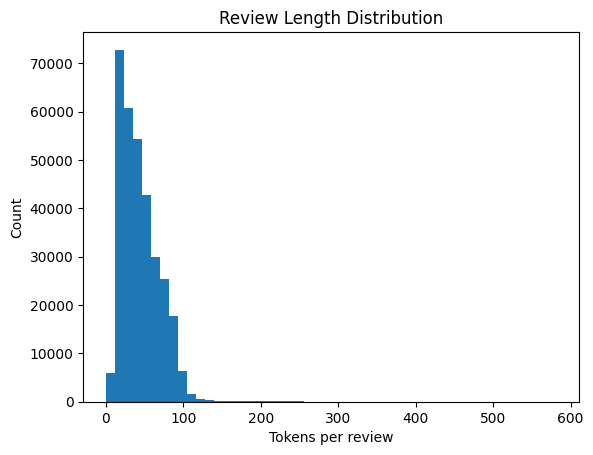

In [17]:
# analyzing review length distribution before padding
lengths = [len(seq) for seq in train_sequences]
plt.hist(lengths, bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Tokens per review")
plt.ylabel("Count")
plt.show()

In [18]:
print("95th percentile length:", np.percentile(lengths, 95))

95th percentile length: 89.0


We pad all input sequences to a fixed length of 164 tokens.
Padding and truncation are applied at the beginning of the sequences ('pre') to ensure uniform input size for the model.

In [19]:
max_len = 89
# pad train seq.
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len, padding='pre', truncating='pre')
# pad test seq.
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding='pre', truncating='pre')

## Word2Vec

We download the pre-trained Google News Word2Vec embeddings (300-dimensional), which will be used for the embeddings in our model. These embeddings are widely used and trained on a large corpus of news articles.

In [20]:
file_id = '1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy'
output_path = 'GoogleNews-vectors-negative300.bin'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output=output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy
From (redirected): https://drive.google.com/uc?id=1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy&confirm=t&uuid=63efa5ab-1093-4099-bbf3-6d4a29c9c66c
To: /content/GoogleNews-vectors-negative300.bin
100%|██████████| 3.64G/3.64G [01:04<00:00, 56.2MB/s]


'GoogleNews-vectors-negative300.bin'

In [21]:
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

We build the embedding matrix by assigning pre-trained Word2Vec vectors to the words in our vocabulary.
Words not found in the Word2Vec model are initialized with random values drawn from a normal distribution (mean = 0, std = 0.6).

In [22]:
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        if word in w2v_model:
            embedding_matrix[i] = w2v_model[word]
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))


## Model Definition

We define a simple neural network architecture consisting of:
- a frozen embedding layer initialized with pre-trained Word2Vec vectors,
- an LSTM layer with 128 units to capture sequential patterns,
- and a final dense layer with sigmoid activation for binary classification.

The model is compiled with binary crossentropy loss and the Adam optimizer.

In [23]:
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


The training accuracy steadily increases across epochs, reaching 94.3%, while the validation accuracy stabilizes around 92.7%, suggesting good generalization without significant overfitting.

After training, we evaluate the model on the test set using standard classification metrics:

- Precision, Recall, and F1-score are all around 0.93 for both sentiment classes (positive and negative).
- The overall accuracy is 93% on a test set of nearly 80,000 samples.
- The confusion matrix shows a balanced performance, with slightly more false positives (~3200) than false negatives (~2500), but no severe class imbalance or skew.

In [24]:
model.fit(train_sequences_padded, y_train, epochs=5,
          validation_split=0.2, batch_size=64)

Epoch 1/5
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.8305 - loss: 0.3794 - val_accuracy: 0.8851 - val_loss: 0.2787
Epoch 2/5
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.8960 - loss: 0.2547 - val_accuracy: 0.9026 - val_loss: 0.2408
Epoch 3/5
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9113 - loss: 0.2198 - val_accuracy: 0.9071 - val_loss: 0.2290
Epoch 4/5
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9239 - loss: 0.1936 - val_accuracy: 0.9101 - val_loss: 0.2249
Epoch 5/5
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9318 - loss: 0.1743 - val_accuracy: 0.9091 - val_loss: 0.2385


In [25]:
y_pred_prob = model.predict(test_sequences_padded)
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

2499/2499 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     39966
           1       0.90      0.92      0.91     39985

    accuracy                           0.91     79951
   macro avg       0.91      0.91      0.91     79951
weighted avg       0.91      0.91      0.91     79951

Confusion Matrix:
[[35982  3984]
 [ 3139 36846]]


The Word2Vec + LSTM model achieves high accuracy and balanced precision/recall, making it effective for binary sentiment classification.
Further improvements could include tuning hyperparameters, using a trainable embedding layer, or incorporating additional text preprocessing